In [1]:
import sys
sys.path.append("..")


# Factor analysis: IPL-VAE

In [2]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable

import vae
import ipl_vae as linvae
import linear_factor as lf_demo

2022-09-24 07:15:04.405815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-24 07:15:04.430529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-24 07:15:05.081306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-24 07:15:05.081419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


In [377]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [4]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_iplvae = jax.random.split(key)

In [345]:
dim_latent = 20 # 20
dim_obs = 100 # 28 ** 2
num_samples = 1_000

In [346]:
pfa = lf_demo.sample_linear_factor_params(key=key_fa_param, dim_obs=dim_obs, dim_latent=dim_latent, isotropic_Psi=False)
samples_latent, samples_observed = lf_demo.sample_linear_factor(key_sample, pfa, num_samples)

In [347]:
A, b = pfa.A, pfa.b
Psi = pfa.Psi * jnp.eye(dim_obs)
marginal_pdf = distrax.MultivariateNormalFullCovariance(loc=b, covariance_matrix=A @ A.T + Psi)

# Bayes-optimal maginal log-likelihood
log_likelihood = marginal_pdf.log_prob(samples_observed).sum()
log_likelihood

DeviceArray(-153454.17, dtype=float32)

## IPL - VAE

In [348]:
key_ipl, key_init_params = jax.random.split(key_iplvae, 2)

In [349]:
class FADecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a Factor Analysis (FA) model
    """
    dim_obs: int
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()
    uniform_init: Callable = nn.initializers.uniform()

    
    def setup(self):
        self.b = self.param("b", self.normal_init, (self.dim_obs,))
        self.A = self.param("A", self.normal_init, (self.dim_obs, self.dim_latent))
        # self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs, self.dim_latent))
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))


    def eval_mean(self, z):
        mean_x = jnp.einsum("...m,dm->...d", z, self.A)+ self.b
        return mean_x
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)

        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    def __call__(self, z):
        mean_x = self.eval_mean(z)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x

    
class Decoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a 
    """
    dim_obs: int
    dim_latent: int = 20
    
    @nn.compact
    def __call__(self, z):
        x = z
        # x = nn.Dense(20)(z)
        # x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs)(x)
        logvar_x = nn.Dense(self.dim_obs)(x)
        return mean_x, logvar_x

In [378]:
class IPL:
    def __init__(self, prior_mu, prior_Sigma, decoder, n_iterations=1):
        self.prior_mu = prior_mu
        self.prior_Sigma = prior_Sigma
        self.decoder = decoder
        self.num_iterations = n_iterations
        self.dim_obs = decoder.dim_obs
        self.dim_latent = decoder.dim_latent
        self.num_is_samples = 13
    

    @partial(jax.jit, static_argnums=(0,))
    def lin_predict(self, mu, Sigma, params):
        m, logPsi = self.decoder.apply(params, mu)
        G = jax.jacfwd(lambda x: self.decoder.apply(params, x)[0])(mu)
        Psi = jnp.exp(logPsi) * jnp.eye(self.dim_obs)
        
        S = jnp.einsum("im,mk,jk->ij", G, Sigma, G)
        S = S + Psi
        C = Sigma @ G.T
        
        return m, S, C

    
    def gauss_condition(self, mu_prev, Sigma_prev, y, m, S, C):
        K = jnp.linalg.solve(S, C.T).T
        mu_est = mu_prev + K @ (y - m)

        Sigma_est = jnp.einsum("im,mk,jk->ij", K, S, K)
        Sigma_est = Sigma_prev - Sigma_est

        return mu_est, Sigma_est
    
    
    def iterate_posterior_step(self, state, y, params):
        """
        Iterate posterior step
        """
        mu, Sigma = state
        m, S, C = self.lin_predict(mu, Sigma, params)
        mu_est, Sigma_est = self.gauss_condition(mu, Sigma, y, m, S, C)
        new_state = (mu_est, Sigma_est)
        return new_state, None
    
    
    def estimate_posterior_params(self, y, params):
        state = (self.prior_mu, self.prior_Sigma)
        ips = partial(self.iterate_posterior_step, params=params)
        
        # lax.scan makes it painfully slow
        for it in range(self.num_iterations):
            state, _ = ips(state, y)
            
        post_mu, post_Sigma = state
        return post_mu, post_Sigma
    

    @partial(jax.jit, static_argnums=(0,))
    def compute_iwlmm_single(self, key, obs, params):
        mu, Sigma = self.estimate_posterior_params(obs, params)
        dist_posterior_latent = tfd.MultivariateNormalFullCovariance(mu, Sigma)
        dist_prior_latent = tfd.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))

        is_samples = dist_posterior_latent.sample(seed=key, sample_shape=self.num_is_samples)
        
        mean_x, logvar_x = self.decoder.apply(params, is_samples)
        
        # cov_x = jax.vmap(jnp.diag)(jnp.exp(logvar_x / 2))
        # dist_decoder = distrax.MultivariateNormalFullCovariance(mean_x, cov_x)

        cov_x = jnp.exp(logvar_x / 2)
        dist_decoder = tfd.MultivariateNormalDiag(mean_x, cov_x)
        

        log_is = (dist_decoder.log_prob(obs)
                + dist_prior_latent.log_prob(is_samples)
                - dist_posterior_latent.log_prob(is_samples))
        
        return jax.nn.logsumexp(log_is, b=1/self.num_is_samples)

In [379]:
batch_init = jnp.ones((1, dim_latent))
decoder = FADecoder(dim_obs, dim_latent)


params_decoder = decoder.init(key_init_params, batch_init)

prior_mu, prior_Sigma = jnp.ones(dim_latent), jnp.eye(dim_latent) * 0.9
ipl_vae = IPL(prior_mu, prior_Sigma, decoder, n_iterations=1)

In [380]:
learning_rate = 1e-4
tx = optax.sgd(-learning_rate)
opt_state = tx.init(params_decoder)

In [381]:
def epoch_step(state, xs, gradfn):
    params, opt_state = state
    key, observation = xs
    
    loss, grads = gradfn(key, observation, params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    state = (params, opt_state)
    
    return state, loss

In [382]:
def run_epoch(key, params_init, opt_state, observations, gradfn):
    keys = jax.random.split(key, len(observations))
    xs = (keys, observations)
    state = (params_init, opt_state)
    state, losses = jax.lax.scan(partial(epoch_step, gradfn=gradfn), state, xs)
    return state, losses

In [383]:
%%time

loss_hist = []
key_epochs = jax.random.split(key_ipl, 100)
gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

for key in tqdm(key_epochs):
    state_final, loss = part_epoch(key, params_decoder, opt_state, samples_observed)
    params_decoder, opt_state = state_final
    loss = loss.sum()
    print(loss, end="\r")
    loss_hist.append(loss.sum())

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3.48 s, sys: 219 ms, total: 3.7 s
Wall time: 21.2 s


Text(0.5, 1.0, 'Marginal log-likelihood')

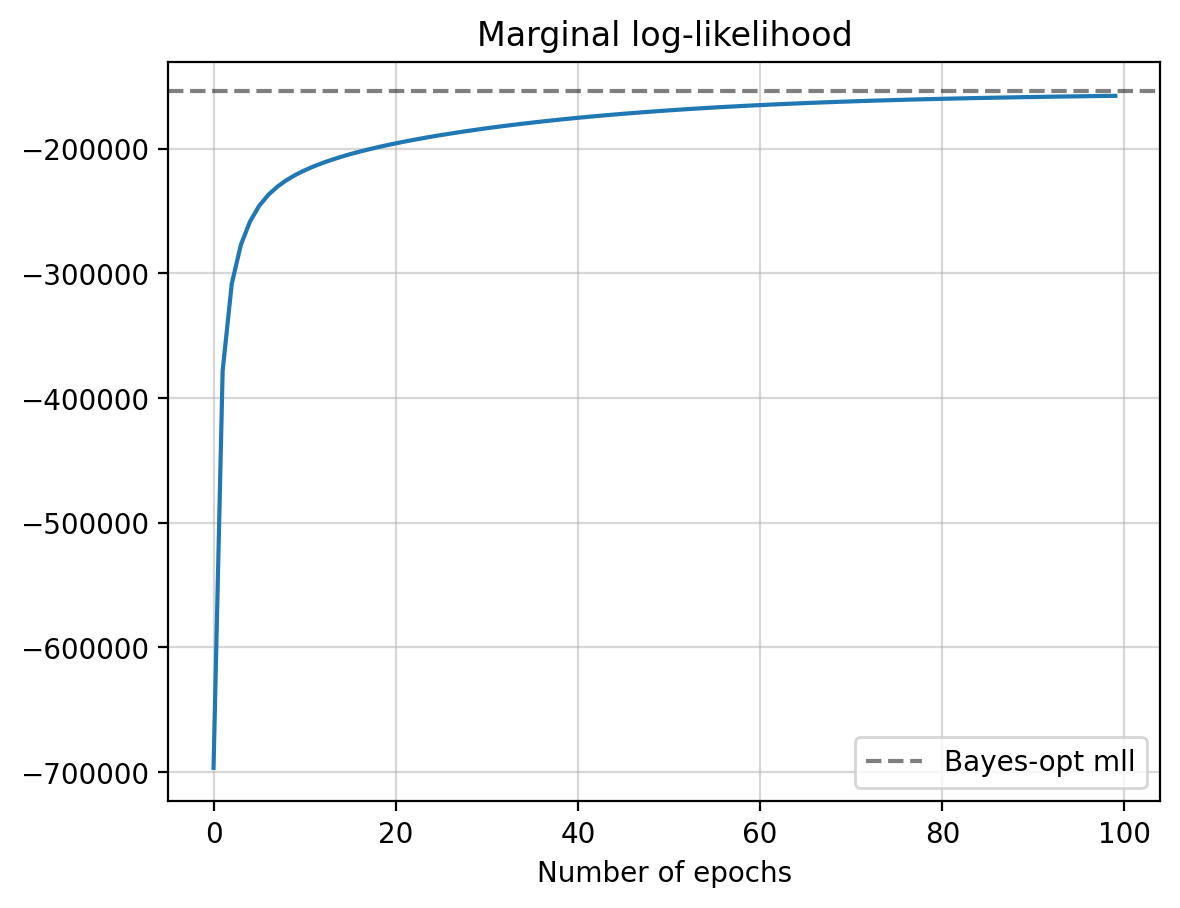

In [384]:
plt.plot(loss_hist)

plt.axhline(y=log_likelihood, color="black", linestyle="--", label="Bayes-opt mll", alpha=0.5)
plt.grid(alpha=0.5)
plt.xlabel("Number of epochs")
plt.legend()
plt.title("Marginal log-likelihood")

## Functional style

In [67]:
key_ipl, key_init_params = jax.random.split(key_iplvae, 2)

In [68]:
def g(z, params):
    return params["A"] @ z + params["b"]


def init_ipl_params(key, dim_full, dim_latent, num_samples, std=1.0):
    key_A_init, key_b_init, key_Psi, key_is = jax.random.split(key, 4)

    mu_prior = jnp.zeros((num_samples, dim_latent))
    Sigma_prior = jnp.ones((num_samples, dim_latent, dim_latent))
    Sigma_prior = Sigma_prior * jnp.eye(dim_latent) * std

    A_est = jax.random.normal(key_A_init, (dim_full, dim_latent))
    b_est = jax.random.normal(key_b_init, (dim_full,))
    Psi_est = jax.random.uniform(key_Psi) # sample_kernel_matrix(key_Psi, dim_full) 

    params = {
        "A": A_est,
        "b": b_est,
        "Psi": Psi_est
    }
    
    return (mu_prior, Sigma_prior), params

In [ ]:
%%time
num_epochs = 500
num_is_samples = 13
alpha = 1e-3
num_iterations = 1
(mu_prior, Sigma_prior), params = init_ipl_params(key_init_params,
                                                  dim_obs, dim_latent,
                                                  num_samples, 0.9)

params, hist_mll_iplvae = linvae.run_ipl_epochs(key_ipl, samples_observed, params, mu_prior, Sigma_prior,
                                 alpha, num_iterations, num_is_samples, num_epochs, g)
params = jax.block_until_ready(params)

In [ ]:
plt.plot(hist_mll_iplvae)

plt.axhline(y=log_likelihood, color="black", linestyle="--", label="Bayes-opt mll", alpha=0.5)
plt.grid(alpha=0.5)
plt.xlabel("Number of epochs")
plt.legend()
plt.title("Marginal log-likelihood")